In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import backend as K
from keras.src.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from imutils import paths

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
                            roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import ngboost as ngb

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
pd.set_option('display.max_colwidth', 400)

In [5]:
df_invariants_1 = pd.read_excel('../invariants_generation/invariants_plusminus1.xlsx')
df_invariants_2 = pd.read_excel('../invariants_generation/invariants_plusminus2.xlsx')
df_invariants_3 = pd.read_excel('../invariants_generation/invariants_plusminus3.xlsx')

df_invariants = df_invariants_1.copy()
df_invariants['degree_assortativity_n2'] = df_invariants_2.degree_assortativity
df_invariants['local_efficiency_n3'] = df_invariants_3.local_efficiency

to_drop = ['degree_centrality', 'average_neighbor_degree', 'global_efficiency', 'wiener_index', 'pagerank']

df_invariants = df_invariants.drop(to_drop, axis=1)
df_invariants

,weight_edges_vertices,weight_edges,average_degree_connectivity,degree_assortativity,local_efficiency,estrada_index,path,label,degree_assortativity_n2,local_efficiency_n3
0,520.593424,149.687664,5.015425,0.440103,0.671236,66820.374058,./cells/1_1_0_1058.jpg,1,0.489919,0.727208
1,517.060547,147.979318,5.076504,0.443647,0.670064,67620.468611,./cells/1_1_0_1060.jpg,1,0.502017,0.725901
2,518.279948,149.259961,5.045749,0.432262,0.671177,66294.535470,./cells/1_1_0_1629.jpg,1,0.482620,0.726291
3,522.733724,149.854237,4.358591,0.438589,0.670367,67210.430387,./cells/1_1_0_1679.jpg,1,0.488614,0.727110
4,519.661458,149.419693,4.697130,0.429179,0.671269,66667.620481,./cells/1_1_0_1784.jpg,1,0.482634,0.725808
...,...,...,...,...,...,...,...,...,...,...
3226,562.224609,158.106371,5.440226,0.445336,0.665721,71389.158287,./cells/108_0_0_9420.jpg,0,0.524694,0.725353
3227,575.970052,162.611892,5.300427,0.443985,0.666581,70454.983447,./cells/108_0_0_954.jpg,0,0.532060,0.725483
3228,561.453125,158.411462,5.548602,0.432528,0.666532,70666.850128,./cells/108_0_0_9558.jpg,0,0.520370,0.726834
3229,569.782878,160.746901,5.409888,0.462416,0.666554,70692.774346,./cells/108_0_0_9688.jpg,0,0.519240,0.726177


In [6]:
root_dir = "../cells"
imagePaths = list(paths.list_images(root_dir))
image_data = []

for imagePath in imagePaths:

    img = cv2.imread(imagePath)
    img = cv2.resize(img, (32, 32))
    image_data.append(img)

In [7]:
len(image_data)

3231

In [8]:
len(imagePaths)

3231

In [9]:
df_paths = pd.DataFrame(imagePaths, columns=['paths'])

In [10]:
df_paths

,paths
0,./cells/72_0_0_4776.jpg
1,./cells/86_0_0_2474.jpg
2,./cells/20_1_0_5041.jpg
3,./cells/6_1_0_4584.jpg
4,./cells/45_0_0_6639.jpg
...,...
3226,./cells/7_1_0_3590.jpg
3227,./cells/13_1_0_8951.jpg
3228,./cells/106_0_0_9927.jpg
3229,./cells/63_1_0_9210.jpg


In [11]:
mean = np.mean(image_data, axis=(1,2), keepdims=True)
std = np.std(image_data, axis=(1,2), keepdims=True)
standardized_images_out = (image_data - mean) / std

In [12]:
df_invariants.head()

,weight_edges_vertices,weight_edges,average_degree_connectivity,degree_assortativity,local_efficiency,estrada_index,degree_assortativity_n2,local_efficiency_n3,path,label
0,520.593424,149.687664,5.015425,0.440103,0.671236,66820.374058,0.489919,0.727208,./cells/1_1_0_1058.jpg,1
1,517.060547,147.979318,5.076504,0.443647,0.670064,67620.468611,0.502017,0.725901,./cells/1_1_0_1060.jpg,1
2,518.279948,149.259961,5.045749,0.432262,0.671177,66294.535470,0.482620,0.726291,./cells/1_1_0_1629.jpg,1
3,522.733724,149.854237,4.358591,0.438589,0.670367,67210.430387,0.488614,0.727110,./cells/1_1_0_1679.jpg,1
4,519.661458,149.419693,4.697130,0.429179,0.671269,66667.620481,0.482634,0.725808,./cells/1_1_0_1784.jpg,1


In [13]:
df_invariants = df_invariants.set_index('path_')
df_invariants = df_invariants.reindex(index = df_paths['paths'])
df_invariants = df_invariants.reset_index()

In [14]:
df_invariants

,paths,weight_edges_vertices,weight_edges,average_degree_connectivity,degree_assortativity,local_efficiency,estrada_index,degree_assortativity_n2,local_efficiency_n3,label
0,./cells/72_0_0_4776.jpg,583.670573,165.745609,5.272956,0.426781,0.667999,69292.542045,0.549325,0.726541,0
1,./cells/86_0_0_2474.jpg,557.674154,158.995360,5.411769,0.428946,0.669045,68518.057028,0.542230,0.729438,0
2,./cells/20_1_0_5041.jpg,522.829102,151.923099,4.498598,0.394458,0.673720,64596.176125,0.461667,0.729302,1
3,./cells/6_1_0_4584.jpg,511.500977,145.493611,5.141163,0.433434,0.668260,68657.049069,0.504442,0.723861,1
4,./cells/45_0_0_6639.jpg,563.638672,159.101167,5.298367,0.441135,0.666568,70486.265807,0.505978,0.724333,0
...,...,...,...,...,...,...,...,...,...,...
3226,./cells/7_1_0_3590.jpg,442.622721,132.103080,4.385265,0.432536,0.680745,60223.429080,0.457836,0.730724,1
3227,./cells/13_1_0_8951.jpg,452.864583,133.192915,4.907787,0.415654,0.676902,62467.729280,0.461201,0.727799,1
3228,./cells/106_0_0_9927.jpg,516.071615,145.433630,5.509780,0.424919,0.666142,70817.592543,0.519894,0.724957,0
3229,./cells/63_1_0_9210.jpg,550.839193,156.205852,5.489367,0.485427,0.667608,69536.667909,0.527128,0.726638,1


In [15]:
df = df_invariants.copy()

In [16]:
df = df.drop('paths', axis=1)

In [17]:
split = train_test_split(df, standardized_images_out, test_size=0.3)

In [18]:
(train, test, trainImagesX, testImagesX) = split

In [19]:
trainY = train.label
testY = test.label

In [20]:
def process_graph_attributes(train, test):

    ss = StandardScaler()
    trainCols = ss.fit_transform(train)
    testCols = ss.transform(test)
    
    return trainCols, testCols

In [21]:
def process_(train, test):
    cols = ["label"]

    trainCols = train.drop(cols,axis=1)
    testCols = test.drop(cols,axis=1)
    
    return trainCols, testCols

In [22]:
trainX, testX = process_(train, test)

In [23]:
trainX, testX = process_graph_attributes(trainX, testX)

In [24]:
trainX = np.asarray(trainX).astype(np.float32)
testX = np.asarray(testX).astype(np.float32)

In [25]:
clf = xgb.XGBClassifier()

clf.fit(trainX, trainY,eval_set=[(trainX, trainY), (testX, testY)], \
        eval_metric=["error", "logloss", "auc"], early_stopping_rounds=5)

[0]	validation_0-error:0.04202	validation_0-logloss:0.47371	validation_0-auc:0.98313	validation_1-error:0.06495	validation_1-logloss:0.48474	validation_1-auc:0.96470
[1]	validation_0-error:0.03715	validation_0-logloss:0.35059	validation_0-auc:0.99139	validation_1-error:0.05567	validation_1-logloss:0.36587	validation_1-auc:0.98388
[2]	validation_0-error:0.03229	validation_0-logloss:0.27156	validation_0-auc:0.99361	validation_1-error:0.05464	validation_1-logloss:0.29222	validation_1-auc:0.98760
[3]	validation_0-error:0.02742	validation_0-logloss:0.21320	validation_0-auc:0.99512	validation_1-error:0.05258	validation_1-logloss:0.24499	validation_1-auc:0.98587
[4]	validation_0-error:0.02388	validation_0-logloss:0.17278	validation_0-auc:0.99592	validation_1-error:0.05464	validation_1-logloss:0.21047	validation_1-auc:0.98643
[5]	validation_0-error:0.02477	validation_0-logloss:0.14498	validation_0-auc:0.99671	validation_1-error:0.05258	validation_1-logloss:0.18305	validation_1-auc:0.98981
[6]	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
y_pred = clf.predict(testX)

In [27]:
print(accuracy_score(testY, y_pred))
print(precision_score(testY, y_pred))
print(recall_score(testY, y_pred))
print(f1_score(testY, y_pred))

0.9608247422680413
0.9627906976744186
0.9495412844036697
0.9561200923787528


In [28]:
results = clf.evals_result()

a = results['validation_0']['error']
a_ = results['validation_1']['error']
predictions = [round(value) for value in y_pred]

In [29]:
b = [1-x for x in a]
c = [1-x for x in a_]

Accuracy: 96.08%


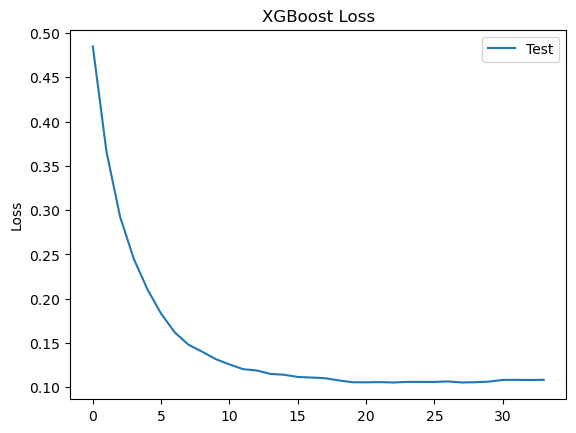

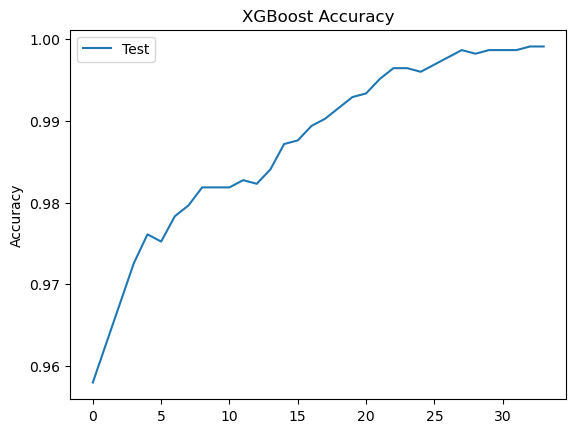

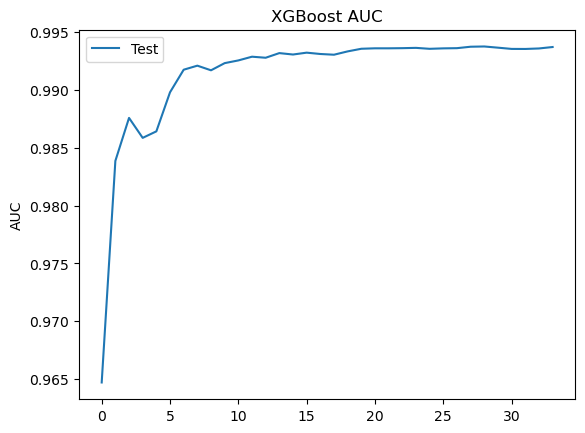

In [30]:
accuracy = accuracy_score(testY, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
results = clf.evals_result()
epochs = len(a)
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Loss')
plt.title('XGBoost Loss')
plt.show()
fig, ax = plt.subplots()
ax.plot(x_axis, b, label='Test')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.show()
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [31]:
def conf_matrix(y_test, y_pred, norm = "true"):
    cm = confusion_matrix(y_test, y_pred, normalize = norm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    return cm.ravel()

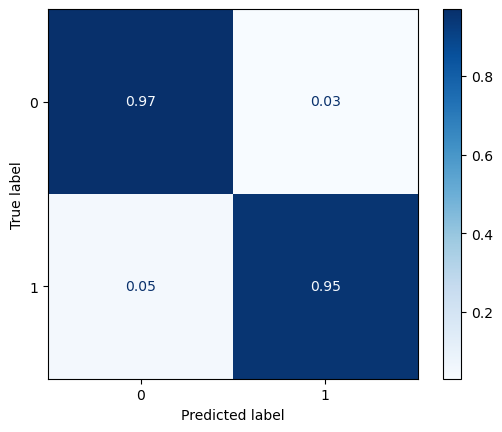

In [32]:
tn_xgb, fp_xgb, fn_xgb, tp_xgb = conf_matrix(testY, y_pred)

In [33]:
tpr_xgb = tp_xgb/(tp_xgb+fn_xgb)
tnr_xgb = 1 - (fp_xgb/(fp_xgb+tn_xgb))

print(tpr_xgb)
print(tnr_xgb)

0.9495412844036697
0.9700374531835206


In [34]:
y_proba = clf.predict_proba(testX)

0.9937764148025978


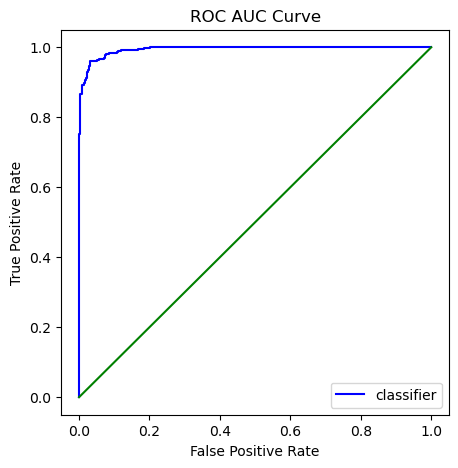

In [35]:
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(color = 'b', label="classifier")
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g', label="ideal")
    plt.title("ROC AUC Curve")

print(roc_auc_score(testY, y_proba[:,1]))
plot_sklearn_roc_curve(testY, y_proba[:, 1])

In [36]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32, 3)))

In [37]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [38]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [39]:
model.compile(loss="binary_crossentropy", metrics=['acc', 'AUC'])

In [40]:
encoder = LabelEncoder()
encoder.fit(trainY)
encoded_y = encoder.transform(trainY)
y_train = to_categorical(encoded_y)

enc = encoder.transform(testY)
y_test = to_categorical(enc)

In [41]:
trainImagesX = np.asarray(trainImagesX).astype(np.float32)
testImagesX = np.asarray(testImagesX).astype(np.float32)

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(trainImagesX,y_train,validation_data=(testImagesX, y_test), epochs=100, batch_size=100, callbacks=[es])

Epoch 1/100
23/23 [==============================] - 6s 154ms/step - loss: 0.6742 - acc: 0.6678 - auc: 0.7239 - val_loss: 0.6178 - val_acc: 0.8495 - val_auc: 0.9347
Epoch 2/100
23/23 [==============================] - 2s 102ms/step - loss: 0.6135 - acc: 0.7899 - auc: 0.8981 - val_loss: 0.5813 - val_acc: 0.8928 - val_auc: 0.9579
Epoch 3/100
23/23 [==============================] - 2s 102ms/step - loss: 0.5873 - acc: 0.8156 - auc: 0.9173 - val_loss: 0.5469 - val_acc: 0.9206 - val_auc: 0.9761
Epoch 4/100
23/23 [==============================] - 3s 113ms/step - loss: 0.5642 - acc: 0.8235 - auc: 0.9260 - val_loss: 0.5337 - val_acc: 0.8887 - val_auc: 0.9517
Epoch 5/100
23/23 [==============================] - 2s 102ms/step - loss: 0.5445 - acc: 0.8169 - auc: 0.9268 - val_loss: 0.4954 - val_acc: 0.9309 - val_auc: 0.9808
Epoch 6/100
23/23 [==============================] - 2s 98ms/step - loss: 0.5250 - acc: 0.8266 - auc: 0.9297 - val_loss: 0.5003 - val_acc: 0.9031 - val_auc: 0.9675
Epoch 7/100

In [43]:
prob = np.round(model.predict(testImagesX),2)
prob

31/31 [==============================] - 2s 32ms/step


array([[0.01, 0.99],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.99, 0.01]], dtype=float32)

In [44]:
pred = np.argmax(prob, axis=1)

In [45]:
print(accuracy_score(testY, pred))
print(precision_score(testY, pred))
print(recall_score(testY, pred))
print(f1_score(testY, pred))

0.9628865979381444
0.9694835680751174
0.9472477064220184
0.9582366589327147


In [46]:
a = history.history['acc']
a_ = history.history['val_acc']

In [47]:
b = [1-x for x in a]
c = [1-x for x in a_]

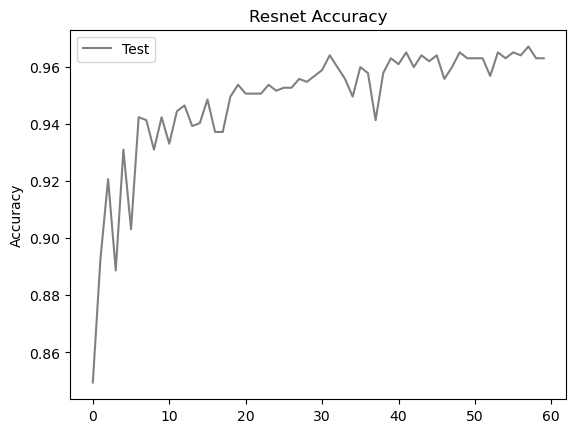

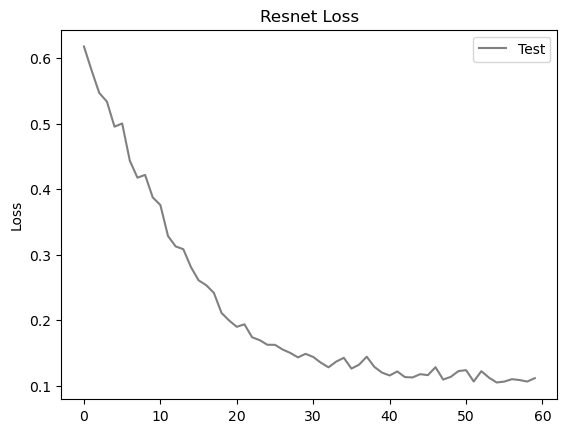

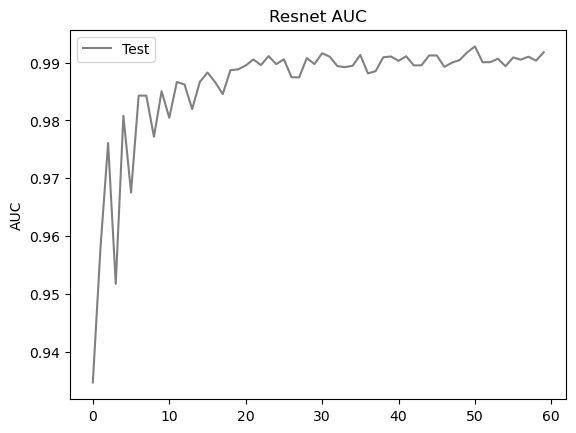

In [48]:
fig, ax = plt.subplots()
ax.plot(history.history['val_acc'], label='Test', color='gray')
ax.legend()
plt.ylabel('Accuracy')
plt.title('Resnet Accuracy')
plt.show()

fig, ax = plt.subplots()
ax.plot(history.history['val_loss'], label='Test', color='gray')
ax.legend()
plt.ylabel('Loss')
plt.title('Resnet Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(history.history['val_auc'], label='Test', color='gray')
ax.legend()
plt.ylabel('AUC')
plt.title('Resnet AUC')
plt.show()

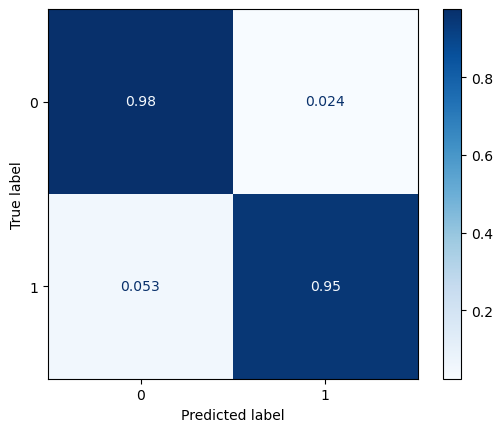

In [49]:
tn_res, fp_res, fn_res, tp_res = conf_matrix(testY, pred)

In [50]:
tpr_res = tp_res/(tp_res+fn_res)
tnr_res = 1 - (fp_res/(fp_res+tn_res))

print(tpr_res)
print(tnr_res)

0.9472477064220184
0.9756554307116105


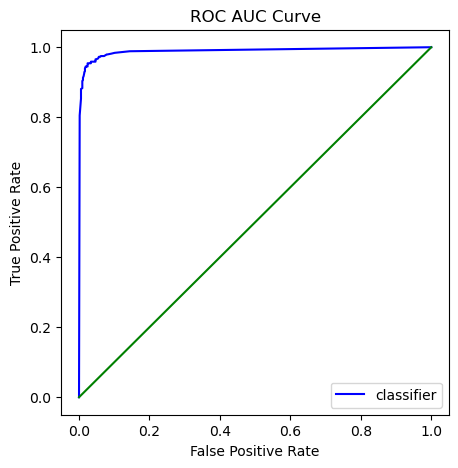

In [51]:
roc_auc_score(testY, prob[:,1])
plot_sklearn_roc_curve(testY, prob[:, 1])

In [52]:
y_pred=clf.predict_proba(testX)
y_pred

array([[2.8340220e-03, 9.9716598e-01],
       [9.8362929e-01, 1.6370706e-02],
       [9.9873453e-01, 1.2654793e-03],
       ...,
       [5.9497356e-04, 9.9940503e-01],
       [9.9742055e-01, 2.5794744e-03],
       [9.9771011e-01, 2.2898647e-03]], dtype=float32)

In [53]:
prob_comb = 1/2*y_pred+1/2*prob

In [54]:
prob_comb

array([[6.4170109e-03, 9.9358296e-01],
       [9.9181461e-01, 8.1853531e-03],
       [9.9936724e-01, 6.3273963e-04],
       ...,
       [2.9748678e-04, 9.9970251e-01],
       [9.9871027e-01, 1.2897372e-03],
       [9.9385506e-01, 6.1449325e-03]], dtype=float32)

In [55]:
pred_comb = np.argmax(prob_comb, axis=1)

In [56]:
print(accuracy_score(testY, pred_comb))
print(precision_score(testY, pred_comb))
print(recall_score(testY, pred_comb))
print(f1_score(testY, pred_comb))

0.9907216494845361
0.9908045977011494
0.9885321100917431
0.9896670493685419


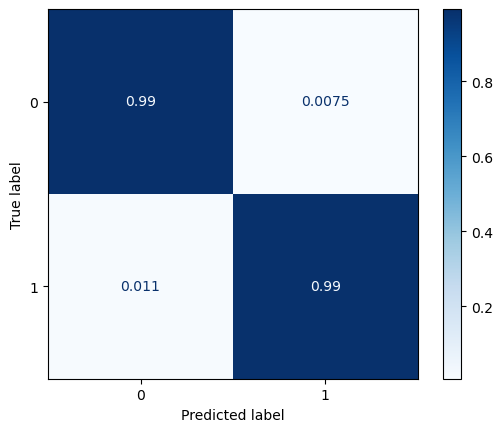

In [57]:
tn_comb, fp_comb, fn_comb, tp_comb = conf_matrix(testY, pred_comb)

In [58]:
tpr_comb = tp_comb/(tp_comb+fn_comb)
tnr_comb = 1 - (fp_comb/(fp_comb+tn_comb))

print(tpr_comb)
print(tnr_comb)

0.9885321100917431
0.9925093632958801


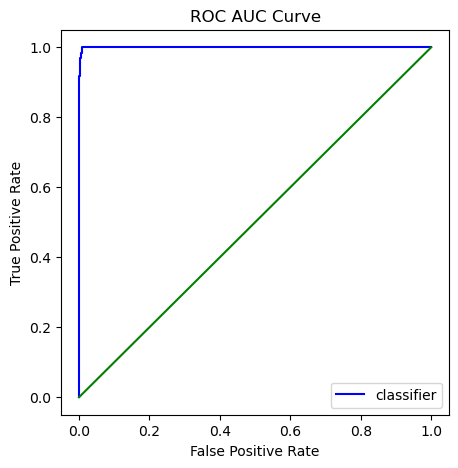

In [59]:
plot_sklearn_roc_curve(testY, prob_comb[:, 1])

In [60]:
clf_rf = GradientBoostingClassifier()
clf_rf.fit(trainX, trainY)

y_pred = clf_rf.predict(testX)

print(accuracy_score(testY, y_pred))
print(precision_score(testY, y_pred))
print(recall_score(testY, y_pred))
print(f1_score(testY, y_pred))

0.9525773195876288
0.9577464788732394
0.9357798165137615
0.9466357308584686


In [61]:
clf = lgb.LGBMClassifier(verbose=0)
clf.fit(trainX, trainY)

y_pred = clf.predict(testX)

print(accuracy_score(testY, y_pred))
print(precision_score(testY, y_pred))
print(recall_score(testY, y_pred))
print(f1_score(testY, y_pred))

0.9608247422680413
0.9693396226415094
0.9426605504587156
0.9558139534883721


In [62]:
clf = ngb.NGBClassifier(verbose=0)
clf.fit(trainX, trainY)

y_pred = clf.predict(testX)

print(accuracy_score(testY, y_pred))
print(precision_score(testY, y_pred))
print(recall_score(testY, y_pred))
print(f1_score(testY, y_pred))

0.945360824742268
0.9570405727923628
0.9197247706422018
0.9380116959064327


In [63]:
clf_rf = AdaBoostClassifier()
clf_rf.fit(trainX, trainY)

y_pred = clf_rf.predict(testX)

print(accuracy_score(testY, y_pred))
print(precision_score(testY, y_pred))
print(recall_score(testY, y_pred))
print(f1_score(testY, y_pred))

0.9525773195876288
0.9534883720930233
0.9403669724770642
0.9468822170900694
